In [1]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress

torch.backends.cudnn.benchmark = True
fastprogress.MAX_COLS = 80

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
# Get Data

In [4]:
from fastai import datasets

In [5]:
path = untar_data(URLs.IMAGENETTE_160)
tfms = get_transforms(do_flip=False)

In [6]:
num_cpus()

8

In [7]:
size = 128 # from https://github.com/fastai/fastai/blob/master/examples/train_imagenette.py#L29
bs = 128
n_gpus = 1
workers = min(8, num_cpus()//n_gpus)

In [8]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imagenette-160/models'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/train')]

In [9]:
data = (ImageList.from_folder(path).split_by_folder(valid='val')
            .label_from_folder().transform(([flip_lr(p=0.5)], []), size=size)
            .databunch(bs=bs, num_workers=workers)
#             .presize(size, scale=(0.35,1))
.normalize(imagenet_stats))

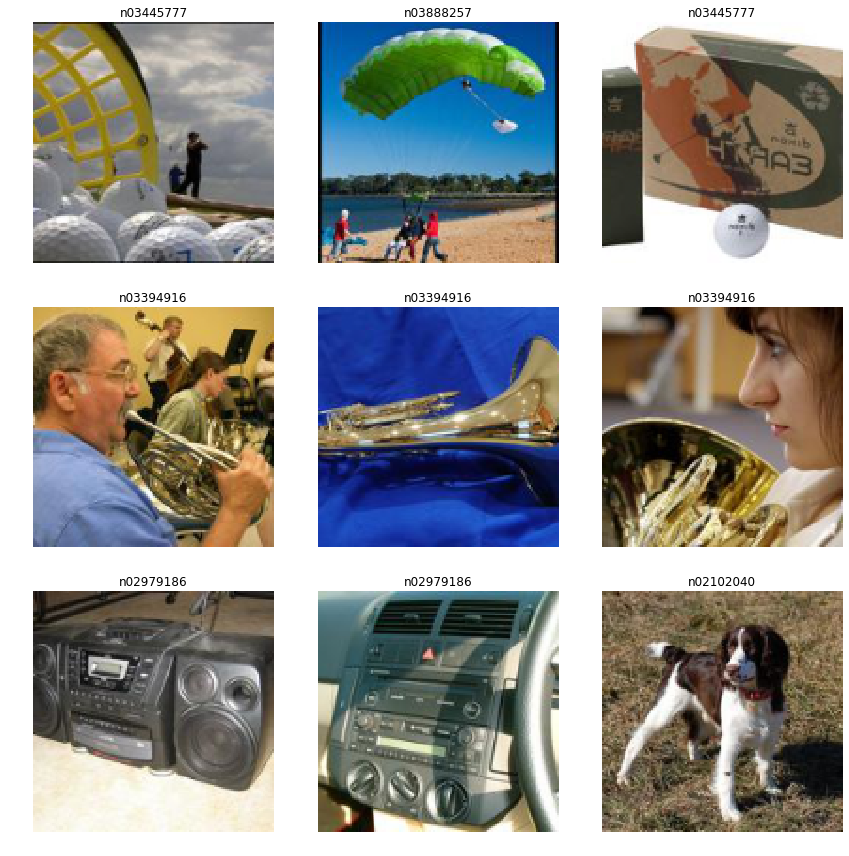

In [10]:
data.show_batch(rows=3)

In [11]:
test_list  = tensor([-0.1, 0, 0.5])

In [12]:
torch.clamp_min(test_list, min=0.0) == F.relu(test_list)

tensor([1, 1, 1], dtype=torch.uint8)

In [13]:
# ??torch.nn.Threshold

In [14]:
# ??torch.nn.ReLU

In [ ]:
class FastReLU(nn.Threshold):
    def __init__(self, threshold=0.0, value=0.0, inplace=False):
        super(FastReLU, self).__init__(threshold, value)
        
        self.threshold = threshold
        self.value = value
        self.inplace = inplace
        
    def forward(self, input):
        return F.threshold(input, self.threshold, self.value, self.inplace) - 0.5
    
    def extra_repr(self):
        inplace_str = 'inplace' if self.inplace else ''
        return inplace_str

In [15]:

class FastReLU(nn.Threshold):
    def __init__(self, threshold=0.0, value=0.0, inplace=False):
        super(FastReLU, self).__init__(threshold, value)
        
        self.threshold = threshold
        self.value = value
        self.inplace = inplace
        
    def forward(self, input):
        return F.threshold(input, self.threshold, self.value, self.inplace) - 0.5
    
    def extra_repr(self):
        inplace_str = 'inplace' if self.inplace else ''
        return inplace_str

In [16]:
m, f = nn.ReLU(), FastReLU()
m(test_list) == f(test_list)

tensor([0, 0, 0], dtype=torch.uint8)

In [17]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class FastBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(FastBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = FastReLU(inplace=True)
#         self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
#         self.relu = FastReLU(inplace=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [18]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [19]:
class FastBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(FastBottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = FastReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [20]:
class FastResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(FastResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = FastReLU(inplace=True)
#         self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [21]:
# ??torchvision.models.resnet.Bottleneck

In [22]:
# ??models.resnet101

In [34]:
def fast_rn18(pretrained=False, **kwargs):
#     print(f"Pretrained: {pretrained}, kwargs: {kwargs}")
    model = FastResNet(FastBasicBlock, [2, 2, 2, 2], **kwargs)
    return model

In [24]:
def base_rn18(pretrained=False, **kwargs):
#     print(f"Pretrained: {pretrained}, kwargs: {kwargs}")
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

In [25]:
def fast_rn101(pretrained=False, **kwargs):
    model = FastResNet(FastBottleneck, [3, 4, 23, 3], **kwargs)
    return model

In [26]:
def base_rn101(pretrained=False, **kwargs):
#     print(f"Pretrained: {pretrained}, kwargs: {kwargs}")
    model = ResNet(BasicBlock, [3, 4, 23, 3], **kwargs)
    return model

In [27]:
# ??cnn_learner

In [28]:
def average_perf(n, model_creator):
    """
    Build n custom learners from scratch and find average accuracy
    """
    acc_list = []
    
    while n > 0:
        custom_learn = cnn_learner(data, model_creator, metrics=accuracy)
        custom_learn.fit_one_cycle(5, 1e-2)
        acc_list.append(custom_learn.recorder.metrics[-1][0].item())
        n-=1
    return acc_list

In [29]:
# acc_list = average_perf(1, base_rn18)

In [30]:
# from statistics import mean
# mean(acc_list)
acc_list = average_perf(1, fast_rn101)
from statistics import mean
mean(acc_list)

epoch,train_loss,valid_loss,accuracy,time
0,2.479718,2.448983,0.114000,00:59
1,2.435970,2.359577,0.108000,00:54
2,2.358128,2.347888,0.130000,00:55
3,2.284657,2.268645,0.130000,00:55
4,2.237480,2.192982,0.210000,00:55


0.20999999344348907

In [31]:
acc_list = average_perf(1, base_rn101)
from statistics import mean
mean(acc_list)

epoch,train_loss,valid_loss,accuracy,time
0,2.395541,2.147473,0.226000,00:27
1,2.235625,2.010147,0.266000,00:26
2,2.024974,1.794728,0.334000,00:26
3,1.863243,1.683333,0.392000,00:26
4,1.756567,1.649689,0.412000,00:26


0.41200000047683716

In [32]:
acc_list = average_perf(5, base_rn18)
from statistics import mean
mean(acc_list)

epoch,train_loss,valid_loss,accuracy,time
0,2.098555,1.730721,0.418000,00:11
1,1.787884,1.525238,0.474000,00:11
2,1.552362,1.362266,0.550000,00:11
3,1.401499,1.221172,0.590000,00:11
4,1.275977,1.209460,0.596000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,2.128381,1.819036,0.386000,00:11
1,1.852758,1.556105,0.472000,00:11
2,1.607351,1.384643,0.530000,00:11
3,1.418920,1.263539,0.566000,00:11
4,1.321764,1.236263,0.584000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,2.106733,1.743058,0.412000,00:11
1,1.768075,1.513309,0.498000,00:11
2,1.527583,1.266570,0.598000,00:11
3,1.350628,1.190383,0.614000,00:11
4,1.251246,1.163184,0.622000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,2.069184,1.665917,0.438000,00:12
1,1.768546,1.534670,0.496000,00:11
2,1.564835,1.370313,0.542000,00:11
3,1.402070,1.254214,0.608000,00:11
4,1.299203,1.241310,0.608000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,2.066176,1.750007,0.390000,00:11
1,1.778054,1.491363,0.502000,00:11
2,1.535607,1.304974,0.588000,00:11
3,1.358580,1.179483,0.618000,00:11
4,1.250585,1.170680,0.604000,00:11


0.6027999877929687

In [35]:
acc_list = average_perf(5, fast_rn18)
from statistics import mean
mean(acc_list)

epoch,train_loss,valid_loss,accuracy,time
0,2.240379,1.969691,0.324000,00:11
1,1.956390,1.619512,0.448000,00:12
2,1.675387,1.412027,0.518000,00:12
3,1.494628,1.338278,0.552000,00:12
4,1.389372,1.324790,0.548000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,2.188680,1.928049,0.328000,00:12
1,1.880131,1.520555,0.494000,00:12
2,1.634752,1.361812,0.542000,00:12
3,1.466148,1.275841,0.570000,00:12
4,1.361514,1.258765,0.574000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,2.243637,1.963604,0.318000,00:12
1,1.898385,1.596071,0.460000,00:12
2,1.639573,1.413456,0.522000,00:12
3,1.463330,1.286765,0.578000,00:12
4,1.365215,1.267282,0.590000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,2.202546,1.823414,0.346000,00:12
1,1.921105,1.662928,0.428000,00:12
2,1.673205,1.425761,0.508000,00:12
3,1.509152,1.342366,0.524000,00:12
4,1.404922,1.316787,0.546000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,2.244579,1.911141,0.330000,00:12
1,1.931163,1.646723,0.426000,00:12
2,1.655246,1.411669,0.522000,00:12
3,1.487061,1.312625,0.556000,00:12
4,1.381669,1.290849,0.560000,00:12


0.5635999917984009